In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
from focal_loss import BinaryFocalLoss
import glob
import rasterio
import numpy as np
from keras.utils import normalize

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the convolutional block
def conv_block(x, filters, filter_size, dropout_rate, batch_norm):
    x = layers.Conv2D(filters, filter_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, filter_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

# Define the gating signal
def gating_signal(input, out_filters, batch_norm):
    x = layers.Conv2D(out_filters, (1, 1))(input)
    if batch_norm:
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    return x


In [3]:
# Define the attention block
def attention_block(x, gating, inter_shape):
    shape_x = x.get_shape()
    shape_g = gating.get_shape()

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = theta_x.get_shape()

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)

    shape_sigmoid = sigmoid_xg.get_shape()
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = tf.tile(upsample_psi, [1, 1, 1, shape_x[3]])

    y = layers.multiply([upsample_psi, x])

    return y

In [9]:
def Attention_UNet(input_shape, NUM_CLASSES=6, dropout_rate=0.0, batch_norm=True):
    # network structure
    FILTER_NUM = 64  # number of basic filters for the first layer
    FILTER_SIZE = 3  # size of the convolutional filter
    UP_SAMP_SIZE = 2  # size of upsampling filters

    # Define 13 input tensors
    input1 = layers.Input(input_shape, dtype=tf.float32)
    input2 = layers.Input(input_shape, dtype=tf.float32)
    input3 = layers.Input(input_shape, dtype=tf.float32)
    input4 = layers.Input(input_shape, dtype=tf.float32)
    input5 = layers.Input(input_shape, dtype=tf.float32)
    input6 = layers.Input(input_shape, dtype=tf.float32)
    input7 = layers.Input(input_shape, dtype=tf.float32)
    input8 = layers.Input(input_shape, dtype=tf.float32)
    input9 = layers.Input(input_shape, dtype=tf.float32)
    input10 = layers.Input(input_shape, dtype=tf.float32)
    input11 = layers.Input(input_shape, dtype=tf.float32)
    input12 = layers.Input(input_shape, dtype=tf.float32)
    input13 = layers.Input(input_shape, dtype=tf.float32)


    # Downsampling layers for the first input
    conv_128_1 = conv_block(input1, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_1)
    conv_64_1 = conv_block(pool_64_1, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_1)
    conv_32_1 = conv_block(pool_32_1, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_1)
    conv_16_1 = conv_block(pool_16_1, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_1)
    conv_8_1 = conv_block(pool_8_1, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)

    # Downsampling layers for the second input
    conv_128_2 = conv_block(input2, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_2)
    conv_64_2 = conv_block(pool_64_2, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_2)
    conv_32_2 = conv_block(pool_32_2, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_2)
    conv_16_2 = conv_block(pool_16_2, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_2)
    conv_8_2 = conv_block(pool_8_2, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the third input
    conv_128_3 = conv_block(input3, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_3)
    conv_64_3 = conv_block(pool_64_3, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_3)
    conv_32_3 = conv_block(pool_32_3, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_3)
    conv_16_3 = conv_block(pool_16_3, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_3)
    conv_8_3 = conv_block(pool_8_3, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
        
    
    # Downsampling layers for the four input
    conv_128_4 = conv_block(input4, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_4)
    conv_64_4 = conv_block(pool_64_4, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_4)
    conv_32_4 = conv_block(pool_32_4, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_4)
    conv_16_4 = conv_block(pool_16_4, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_4)
    conv_8_4 = conv_block(pool_8_4, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the five input
    conv_128_5 = conv_block(input5, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_5 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_5)
    conv_64_5 = conv_block(pool_64_5, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_5 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_5)
    conv_32_5 = conv_block(pool_32_5, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_5 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_5)
    conv_16_5 = conv_block(pool_16_5, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_5 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_5)
    conv_8_5 = conv_block(pool_8_5, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the six input
    conv_128_6 = conv_block(input6, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_6 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_6)
    conv_64_6 = conv_block(pool_64_6, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_6 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_6)
    conv_32_6 = conv_block(pool_32_6, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_6 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_6)
    conv_16_6 = conv_block(pool_16_6, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_6 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_6)
    conv_8_6 = conv_block(pool_8_6, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the seven input
    conv_128_7 = conv_block(input7, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_7 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_7)
    conv_64_7 = conv_block(pool_64_7, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_7 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_7)
    conv_32_7 = conv_block(pool_32_7, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_7 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_7)
    conv_16_7 = conv_block(pool_16_7, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_7 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_7)
    conv_8_7 = conv_block(pool_8_7, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the Eight input
    conv_128_8 = conv_block(input8, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_8)
    conv_64_8 = conv_block(pool_64_8, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_8)
    conv_32_8 = conv_block(pool_32_8, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_8)
    conv_16_8 = conv_block(pool_16_8, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_8)
    conv_8_8 = conv_block(pool_8_8, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the Nine input
    conv_128_9 = conv_block(input9, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_9 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_9)
    conv_64_9 = conv_block(pool_64_9, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_9 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_9)
    conv_32_9 = conv_block(pool_32_9, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_9 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_9)
    conv_16_9 = conv_block(pool_16_9, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_9 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_9)
    conv_8_9 = conv_block(pool_8_9, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the Ten input
    conv_128_10 = conv_block(input10, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_10 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_10)
    conv_64_10 = conv_block(pool_64_10, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_10 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_10)
    conv_32_10 = conv_block(pool_32_10, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_10 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_10)
    conv_16_10 = conv_block(pool_16_10, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_10 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_10)
    conv_8_10 = conv_block(pool_8_10, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the Eleven input
    conv_128_11 = conv_block(input11, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_11 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_11)
    conv_64_11 = conv_block(pool_64_11, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_11 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_11)
    conv_32_11 = conv_block(pool_32_11, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_11 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_11)
    conv_16_11 = conv_block(pool_16_11, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_11 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_11)
    conv_8_11 = conv_block(pool_8_11, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Downsampling layers for the Twelve input
    conv_128_12 = conv_block(input12, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_12 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_12)
    conv_64_12 = conv_block(pool_64_12, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_12 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_12)
    conv_32_12 = conv_block(pool_32_12, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_12 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_12)
    conv_16_12 = conv_block(pool_16_12, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_12 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_12)
    conv_8_12 = conv_block(pool_8_12, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)

    
    # Downsampling layers for the Thirteen input
    conv_128_13 = conv_block(input13, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64_13 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128_13)
    conv_64_13 = conv_block(pool_64_13, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32_13 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64_13)
    conv_32_13 = conv_block(pool_32_13, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16_13 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32_13)
    conv_16_13 = conv_block(pool_16_13, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8_13 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16_13)
    conv_8_13 = conv_block(pool_8_13, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)


    # Upsampling layers and attention blocks for the first input
    gating_16_1 = gating_signal(conv_8_1, 8 * FILTER_NUM, batch_norm)
    att_16_1 = attention_block(conv_16_1, gating_16_1, 8 * FILTER_NUM)
    up_16_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_1)
    up_16_1 = layers.concatenate([up_16_1, att_16_1], axis=3)
    up_conv_16_1 = conv_block(up_16_1, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_1 = gating_signal(up_conv_16_1, 4 * FILTER_NUM, batch_norm)
    att_32_1 = attention_block(conv_32_1, gating_32_1, 4 * FILTER_NUM)
    up_32_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_1)
    up_32_1 = layers.concatenate([up_32_1, att_32_1], axis=3)
    up_conv_32_1 = conv_block(up_32_1, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_1 = gating_signal(up_conv_32_1, 2 * FILTER_NUM, batch_norm)
    att_64_1 = attention_block(conv_64_1, gating_64_1, 2 * FILTER_NUM)
    up_64_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_1)
    up_64_1 = layers.concatenate([up_64_1, att_64_1], axis=3)
    up_conv_64_1 = conv_block(up_64_1, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_1 = gating_signal(up_conv_64_1, FILTER_NUM, batch_norm)
    att_128_1 = attention_block(conv_128_1, gating_128_1, FILTER_NUM)
    up_128_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_1)
    up_128_1 = layers.concatenate([up_128_1, att_128_1], axis=3)
    up_conv_128_1 = conv_block(up_128_1, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the second input
    gating_16_2 = gating_signal(conv_8_2, 8 * FILTER_NUM, batch_norm)
    att_16_2 = attention_block(conv_16_2, gating_16_2, 8 * FILTER_NUM)
    up_16_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_2)
    up_16_2 = layers.concatenate([up_16_2, att_16_2], axis=3)
    up_conv_16_2 = conv_block(up_16_2, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_2 = gating_signal(up_conv_16_2, 4 * FILTER_NUM, batch_norm)
    att_32_2 = attention_block(conv_32_2, gating_32_2, 4 * FILTER_NUM)
    up_32_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_2)
    up_32_2 = layers.concatenate([up_32_2, att_32_2], axis=3)
    up_conv_32_2 = conv_block(up_32_2, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_2 = gating_signal(up_conv_32_2, 2 * FILTER_NUM, batch_norm)
    att_64_2 = attention_block(conv_64_2, gating_64_2, 2 * FILTER_NUM)
    up_64_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_2)
    up_64_2 = layers.concatenate([up_64_2, att_64_2], axis=3)
    up_conv_64_2 = conv_block(up_64_2, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_2 = gating_signal(up_conv_64_2, FILTER_NUM, batch_norm)
    att_128_2 = attention_block(conv_128_2, gating_128_2, FILTER_NUM)
    up_128_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_2)
    up_128_2 = layers.concatenate([up_128_2, att_128_2], axis=3)
    up_conv_128_2 = conv_block(up_128_2, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Upsampling layers and attention blocks for the Third input
    gating_16_3 = gating_signal(conv_8_3, 8 * FILTER_NUM, batch_norm)
    att_16_3 = attention_block(conv_16_3, gating_16_3, 8 * FILTER_NUM)
    up_16_3 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_3)
    up_16_3 = layers.concatenate([up_16_3, att_16_3], axis=3)
    up_conv_16_3 = conv_block(up_16_3, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_3 = gating_signal(up_conv_16_3, 4 * FILTER_NUM, batch_norm)
    att_32_3 = attention_block(conv_32_3, gating_32_3, 4 * FILTER_NUM)
    up_32_3 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_3)
    up_32_3 = layers.concatenate([up_32_3, att_32_3], axis=3)
    up_conv_32_3 = conv_block(up_32_3, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_3 = gating_signal(up_conv_32_3, 2 * FILTER_NUM, batch_norm)
    att_64_3 = attention_block(conv_64_3, gating_64_3, 2 * FILTER_NUM)
    up_64_3 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_3)
    up_64_3 = layers.concatenate([up_64_3, att_64_3], axis=3)
    up_conv_64_3 = conv_block(up_64_3, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_3 = gating_signal(up_conv_64_3, FILTER_NUM, batch_norm)
    att_128_3 = attention_block(conv_128_3, gating_128_3, FILTER_NUM)
    up_128_3 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_3)
    up_128_3 = layers.concatenate([up_128_3, att_128_3], axis=3)
    up_conv_128_3 = conv_block(up_128_3, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Fourth input
    gating_16_4 = gating_signal(conv_8_4, 8 * FILTER_NUM, batch_norm)
    att_16_4 = attention_block(conv_16_4, gating_16_4, 8 * FILTER_NUM)
    up_16_4 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_4)
    up_16_4 = layers.concatenate([up_16_4, att_16_4], axis=3)
    up_conv_16_4 = conv_block(up_16_4, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_4 = gating_signal(up_conv_16_4, 4 * FILTER_NUM, batch_norm)
    att_32_4 = attention_block(conv_32_4, gating_32_4, 4 * FILTER_NUM)
    up_32_4 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_4)
    up_32_4 = layers.concatenate([up_32_4, att_32_4], axis=3)
    up_conv_32_4 = conv_block(up_32_4, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_4 = gating_signal(up_conv_32_4, 2 * FILTER_NUM, batch_norm)
    att_64_4 = attention_block(conv_64_4, gating_64_4, 2 * FILTER_NUM)
    up_64_4 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_4)
    up_64_4 = layers.concatenate([up_64_4, att_64_4], axis=3)
    up_conv_64_4 = conv_block(up_64_4, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_4 = gating_signal(up_conv_64_4, FILTER_NUM, batch_norm)
    att_128_4 = attention_block(conv_128_4, gating_128_4, FILTER_NUM)
    up_128_4 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_4)
    up_128_4 = layers.concatenate([up_128_4, att_128_4], axis=3)
    up_conv_128_4 = conv_block(up_128_4, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

     # Upsampling layers and attention blocks for the Fifth input
    gating_16_5 = gating_signal(conv_8_5, 8 * FILTER_NUM, batch_norm)
    att_16_5 = attention_block(conv_16_5, gating_16_5, 8 * FILTER_NUM)
    up_16_5 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_5)
    up_16_5 = layers.concatenate([up_16_5, att_16_5], axis=3)
    up_conv_16_5 = conv_block(up_16_5, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_5 = gating_signal(up_conv_16_5, 4 * FILTER_NUM, batch_norm)
    att_32_5 = attention_block(conv_32_5, gating_32_5, 4 * FILTER_NUM)
    up_32_5 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_5)
    up_32_5 = layers.concatenate([up_32_5, att_32_5], axis=3)
    up_conv_32_5 = conv_block(up_32_5, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_5 = gating_signal(up_conv_32_5, 2 * FILTER_NUM, batch_norm)
    att_64_5 = attention_block(conv_64_5, gating_64_5, 2 * FILTER_NUM)
    up_64_5 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_5)
    up_64_5 = layers.concatenate([up_64_5, att_64_5], axis=3)
    up_conv_64_5 = conv_block(up_64_5, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_5 = gating_signal(up_conv_64_5, FILTER_NUM, batch_norm)
    att_128_5 = attention_block(conv_128_5, gating_128_5, FILTER_NUM)
    up_128_5 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_5)
    up_128_5 = layers.concatenate([up_128_5, att_128_5], axis=3)
    up_conv_128_5 = conv_block(up_128_5, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
  
    # Upsampling layers and attention blocks for the Sixth input
    gating_16_6 = gating_signal(conv_8_6, 8 * FILTER_NUM, batch_norm)
    att_16_6 = attention_block(conv_16_6, gating_16_6, 8 * FILTER_NUM)
    up_16_6 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_6)
    up_16_6 = layers.concatenate([up_16_6, att_16_6], axis=3)
    up_conv_16_6 = conv_block(up_16_6, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_6 = gating_signal(up_conv_16_6, 4 * FILTER_NUM, batch_norm)
    att_32_6 = attention_block(conv_32_6, gating_32_6, 4 * FILTER_NUM)
    up_32_6 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_6)
    up_32_6 = layers.concatenate([up_32_6, att_32_6], axis=3)
    up_conv_32_6 = conv_block(up_32_6, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_6 = gating_signal(up_conv_32_6, 2 * FILTER_NUM, batch_norm)
    att_64_6 = attention_block(conv_64_6, gating_64_6, 2 * FILTER_NUM)
    up_64_6 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_6)
    up_64_6 = layers.concatenate([up_64_6, att_64_6], axis=3)
    up_conv_64_6 = conv_block(up_64_6, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_6 = gating_signal(up_conv_64_6, FILTER_NUM, batch_norm)
    att_128_6 = attention_block(conv_128_6, gating_128_6, FILTER_NUM)
    up_128_6 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_6)
    up_128_6 = layers.concatenate([up_128_6, att_128_6], axis=3)
    up_conv_128_6 = conv_block(up_128_6, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Seventh input
    gating_16_7 = gating_signal(conv_8_7, 8 * FILTER_NUM, batch_norm)
    att_16_7 = attention_block(conv_16_7, gating_16_7, 8 * FILTER_NUM)
    up_16_7 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_7)
    up_16_7 = layers.concatenate([up_16_7, att_16_7], axis=3)
    up_conv_16_7 = conv_block(up_16_7, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_7 = gating_signal(up_conv_16_7, 4 * FILTER_NUM, batch_norm)
    att_32_7 = attention_block(conv_32_7, gating_32_7, 4 * FILTER_NUM)
    up_32_7 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_7)
    up_32_7 = layers.concatenate([up_32_7, att_32_7], axis=3)
    up_conv_32_7 = conv_block(up_32_7, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_7 = gating_signal(up_conv_32_7, 2 * FILTER_NUM, batch_norm)
    att_64_7 = attention_block(conv_64_7, gating_64_7, 2 * FILTER_NUM)
    up_64_7 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_7)
    up_64_7 = layers.concatenate([up_64_7, att_64_7], axis=3)
    up_conv_64_7 = conv_block(up_64_7, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_7 = gating_signal(up_conv_64_7, FILTER_NUM, batch_norm)
    att_128_7 = attention_block(conv_128_7, gating_128_7, FILTER_NUM)
    up_128_7 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_7)
    up_128_7 = layers.concatenate([up_128_7, att_128_7], axis=3)
    up_conv_128_7 = conv_block(up_128_7, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Eighth input
    gating_16_8 = gating_signal(conv_8_8, 8 * FILTER_NUM, batch_norm)
    att_16_8 = attention_block(conv_16_8, gating_16_8, 8 * FILTER_NUM)
    up_16_8 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_8)
    up_16_8 = layers.concatenate([up_16_8, att_16_8], axis=3)
    up_conv_16_8 = conv_block(up_16_8, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_8 = gating_signal(up_conv_16_8, 4 * FILTER_NUM, batch_norm)
    att_32_8 = attention_block(conv_32_8, gating_32_8, 4 * FILTER_NUM)
    up_32_8 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_8)
    up_32_8 = layers.concatenate([up_32_8, att_32_8], axis=3)
    up_conv_32_8 = conv_block(up_32_8, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_8 = gating_signal(up_conv_32_8, 2 * FILTER_NUM, batch_norm)
    att_64_8 = attention_block(conv_64_8, gating_64_8, 2 * FILTER_NUM)
    up_64_8 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_8)
    up_64_8 = layers.concatenate([up_64_8, att_64_8], axis=3)
    up_conv_64_8 = conv_block(up_64_8, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_8 = gating_signal(up_conv_64_8, FILTER_NUM, batch_norm)
    att_128_8 = attention_block(conv_128_8, gating_128_8, FILTER_NUM)
    up_128_8 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_8)
    up_128_8 = layers.concatenate([up_128_8, att_128_8], axis=3)
    up_conv_128_8 = conv_block(up_128_8, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Ninth input
    gating_16_9 = gating_signal(conv_8_9, 8 * FILTER_NUM, batch_norm)
    att_16_9 = attention_block(conv_16_9, gating_16_9, 8 * FILTER_NUM)
    up_16_9 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_9)
    up_16_9 = layers.concatenate([up_16_9, att_16_9], axis=3)
    up_conv_16_9 = conv_block(up_16_9, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_9 = gating_signal(up_conv_16_9, 4 * FILTER_NUM, batch_norm)
    att_32_9 = attention_block(conv_32_9, gating_32_9, 4 * FILTER_NUM)
    up_32_9 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_9)
    up_32_9 = layers.concatenate([up_32_9, att_32_9], axis=3)
    up_conv_32_9 = conv_block(up_32_9, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_9 = gating_signal(up_conv_32_9, 2 * FILTER_NUM, batch_norm)
    att_64_9 = attention_block(conv_64_9, gating_64_9, 2 * FILTER_NUM)
    up_64_9 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_9)
    up_64_9 = layers.concatenate([up_64_9, att_64_9], axis=3)
    up_conv_64_9 = conv_block(up_64_9, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_9 = gating_signal(up_conv_64_9, FILTER_NUM, batch_norm)
    att_128_9 = attention_block(conv_128_9, gating_128_9, FILTER_NUM)
    up_128_9 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_9)
    up_128_9 = layers.concatenate([up_128_9, att_128_9], axis=3)
    up_conv_128_9 = conv_block(up_128_9, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Tenth input
    gating_16_10 = gating_signal(conv_8_10, 8 * FILTER_NUM, batch_norm)
    att_16_10 = attention_block(conv_16_10, gating_16_10, 8 * FILTER_NUM)
    up_16_10 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_10)
    up_16_10 = layers.concatenate([up_16_10, att_16_10], axis=3)
    up_conv_16_10 = conv_block(up_16_10, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_10 = gating_signal(up_conv_16_10, 4 * FILTER_NUM, batch_norm)
    att_32_10 = attention_block(conv_32_10, gating_32_10, 4 * FILTER_NUM)
    up_32_10 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_10)
    up_32_10 = layers.concatenate([up_32_10, att_32_10], axis=3)
    up_conv_32_10 = conv_block(up_32_10, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_10 = gating_signal(up_conv_32_10, 2 * FILTER_NUM, batch_norm)
    att_64_10 = attention_block(conv_64_10, gating_64_10, 2 * FILTER_NUM)
    up_64_10 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_10)
    up_64_10 = layers.concatenate([up_64_10, att_64_10], axis=3)
    up_conv_64_10 = conv_block(up_64_10, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_10 = gating_signal(up_conv_64_10, FILTER_NUM, batch_norm)
    att_128_10 = attention_block(conv_128_10, gating_128_10, FILTER_NUM)
    up_128_10 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_10)
    up_128_10 = layers.concatenate([up_128_10, att_128_10], axis=3)
    up_conv_128_10 = conv_block(up_128_10, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Eleventh input
    gating_16_11 = gating_signal(conv_8_11, 8 * FILTER_NUM, batch_norm)
    att_16_11 = attention_block(conv_16_11, gating_16_11, 8 * FILTER_NUM)
    up_16_11 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_11)
    up_16_11 = layers.concatenate([up_16_11, att_16_11], axis=3)
    up_conv_16_11 = conv_block(up_16_11, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_11 = gating_signal(up_conv_16_11, 4 * FILTER_NUM, batch_norm)
    att_32_11 = attention_block(conv_32_11, gating_32_11, 4 * FILTER_NUM)
    up_32_11 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_11)
    up_32_11 = layers.concatenate([up_32_11, att_32_11], axis=3)
    up_conv_32_11 = conv_block(up_32_11, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_11 = gating_signal(up_conv_32_11, 2 * FILTER_NUM, batch_norm)
    att_64_11 = attention_block(conv_64_11, gating_64_11, 2 * FILTER_NUM)
    up_64_11 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_11)
    up_64_11 = layers.concatenate([up_64_11, att_64_11], axis=3)
    up_conv_64_11 = conv_block(up_64_11, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_11 = gating_signal(up_conv_64_11, FILTER_NUM, batch_norm)
    att_128_11 = attention_block(conv_128_11, gating_128_11, FILTER_NUM)
    up_128_11 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_11)
    up_128_11 = layers.concatenate([up_128_11, att_128_11], axis=3)
    up_conv_128_11 = conv_block(up_128_11, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Twelfth input
    gating_16_12 = gating_signal(conv_8_12, 8 * FILTER_NUM, batch_norm)
    att_16_12 = attention_block(conv_16_12, gating_16_12, 8 * FILTER_NUM)
    up_16_12 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_12)
    up_16_12 = layers.concatenate([up_16_12, att_16_12], axis=3)
    up_conv_16_12 = conv_block(up_16_12, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_12 = gating_signal(up_conv_16_12, 4 * FILTER_NUM, batch_norm)
    att_32_12 = attention_block(conv_32_12, gating_32_12, 4 * FILTER_NUM)
    up_32_12 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_12)
    up_32_12 = layers.concatenate([up_32_12, att_32_12], axis=3)
    up_conv_32_12 = conv_block(up_32_12, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_12 = gating_signal(up_conv_32_12, 2 * FILTER_NUM, batch_norm)
    att_64_12 = attention_block(conv_64_12, gating_64_12, 2 * FILTER_NUM)
    up_64_12 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_12)
    up_64_12 = layers.concatenate([up_64_12, att_64_12], axis=3)
    up_conv_64_12 = conv_block(up_64_12, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_12 = gating_signal(up_conv_64_12, FILTER_NUM, batch_norm)
    att_128_12 = attention_block(conv_128_12, gating_128_12, FILTER_NUM)
    up_128_12 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_12)
    up_128_12 = layers.concatenate([up_128_12, att_128_12], axis=3)
    up_conv_128_12 = conv_block(up_128_12, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers and attention blocks for the Thirteenth input
    gating_16_13 = gating_signal(conv_8_13, 8 * FILTER_NUM, batch_norm)
    att_16_13 = attention_block(conv_16_13, gating_16_13, 8 * FILTER_NUM)
    up_16_13 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8_13)
    up_16_13 = layers.concatenate([up_16_13, att_16_13], axis=3)
    up_conv_16_13 = conv_block(up_16_13, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    gating_32_13 = gating_signal(up_conv_16_13, 4 * FILTER_NUM, batch_norm)
    att_32_13 = attention_block(conv_32_13, gating_32_13, 4 * FILTER_NUM)
    up_32_13 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16_13)
    up_32_13 = layers.concatenate([up_32_13, att_32_13], axis=3)
    up_conv_32_13 = conv_block(up_32_13, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)

    gating_64_13 = gating_signal(up_conv_32_13, 2 * FILTER_NUM, batch_norm)
    att_64_13 = attention_block(conv_64_13, gating_64_13, 2 * FILTER_NUM)
    up_64_13 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32_13)
    up_64_13 = layers.concatenate([up_64_13, att_64_13], axis=3)
    up_conv_64_13 = conv_block(up_64_13, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)

    gating_128_13 = gating_signal(up_conv_64_13, FILTER_NUM, batch_norm)
    att_128_13 = attention_block(conv_128_13, gating_128_13, FILTER_NUM)
    up_128_13 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64_13)
    up_128_13 = layers.concatenate([up_128_13, att_128_13], axis=3)
    up_conv_128_13 = conv_block(up_128_13, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    
    
    # Merge the two sets of upsampling results
    merged = layers.concatenate([up_conv_128_1, up_conv_128_2, up_conv_128_3, up_conv_128_4, up_conv_128_5,
                            up_conv_128_6, up_conv_128_7, up_conv_128_8, up_conv_128_9, up_conv_128_10,
                            up_conv_128_11, up_conv_128_12, up_conv_128_13], axis=3)


    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1))(merged)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model integration with two inputs
    model = models.Model(inputs=[input1, input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13], outputs=conv_final, name="Attention_UNet")
    return model

# Example usage:
input_shape = (64, 64, 1)  # Adjust input shape as needed
num_inputs = 13  # Number of input tensors
model = Attention_UNet(input_shape, NUM_CLASSES=6, dropout_rate=0.0, batch_norm=True)
model.summary()


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 input_42 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 input_43 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                     

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_961 (B  (None, 64, 64, 3)            12        ['conv2d_1429[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_971 (B  (None, 64, 64, 3)            12        ['conv2d_1439[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_981 (B  (None, 64, 64, 3)            12        ['conv2d_1449[0][0]']         
 atchNormalization)                                                                               
          

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_892 (B  (None, 64, 64, 3)            12        ['conv2d_1360[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_902 (B  (None, 64, 64, 3)            12        ['conv2d_1370[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_912 (B  (None, 64, 64, 3)            12        ['conv2d_1380[0][0]']         
 atchNormalization)                                                                               
          

 max_pooling2d_172 (MaxPool  (None, 32, 32, 3)            0         ['activation_1214[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_176 (MaxPool  (None, 32, 32, 3)            0         ['activation_1224[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_180 (MaxPool  (None, 32, 32, 3)            0         ['activation_1234[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_184 (MaxPool  (None, 32, 32, 3)            0         ['activation_1244[0][0]']     
 ing2D)   

 batch_normalization_963 (B  (None, 32, 32, 3)            12        ['conv2d_1431[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_973 (B  (None, 32, 32, 3)            12        ['conv2d_1441[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_983 (B  (None, 32, 32, 3)            12        ['conv2d_1451[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 activation_1175 (Activatio  (None, 32, 32, 3)            0         ['batch_normalization_863[0][0
 n)       

 batch_normalization_894 (B  (None, 32, 32, 3)            12        ['conv2d_1362[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_904 (B  (None, 32, 32, 3)            12        ['conv2d_1372[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_914 (B  (None, 32, 32, 3)            12        ['conv2d_1382[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_924 (B  (None, 32, 32, 3)            12        ['conv2d_1392[0][0]']         
 atchNorma

                                                                                                  
 max_pooling2d_177 (MaxPool  (None, 16, 16, 3)            0         ['activation_1226[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_181 (MaxPool  (None, 16, 16, 3)            0         ['activation_1236[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_185 (MaxPool  (None, 16, 16, 3)            0         ['activation_1246[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooli

                                                                                                  
 batch_normalization_975 (B  (None, 16, 16, 3)            12        ['conv2d_1443[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_985 (B  (None, 16, 16, 3)            12        ['conv2d_1453[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 activation_1177 (Activatio  (None, 16, 16, 3)            0         ['batch_normalization_865[0][0
 n)                                                                 ]']                           
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_906 (B  (None, 16, 16, 3)            12        ['conv2d_1374[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_916 (B  (None, 16, 16, 3)            12        ['conv2d_1384[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_926 (B  (None, 16, 16, 3)            12        ['conv2d_1394[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_182 (MaxPool  (None, 8, 8, 3)              0         ['activation_1238[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_186 (MaxPool  (None, 8, 8, 3)              0         ['activation_1248[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_190 (MaxPool  (None, 8, 8, 3)              0         ['activation_1258[0][0]']     
 ing2D)                                                                                           
          

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_987 (B  (None, 8, 8, 3)              12        ['conv2d_1455[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 activation_1179 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_867[0][0
 n)                                                                 ]']                           
                                                                                                  
 activation_1189 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_877[0][0
 n)                                                                 ]']                           
          

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_918 (B  (None, 8, 8, 3)              12        ['conv2d_1386[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_928 (B  (None, 8, 8, 3)              12        ['conv2d_1396[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_938 (B  (None, 8, 8, 3)              12        ['conv2d_1406[0][0]']         
 atchNormalization)                                                                               
          

 max_pooling2d_183 (MaxPool  (None, 4, 4, 3)              0         ['activation_1240[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_187 (MaxPool  (None, 4, 4, 3)              0         ['activation_1250[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_191 (MaxPool  (None, 4, 4, 3)              0         ['activation_1260[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_195 (MaxPool  (None, 4, 4, 3)              0         ['activation_1270[0][0]']     
 ing2D)   

 batch_normalization_989 (B  (None, 4, 4, 3)              12        ['conv2d_1457[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 activation_1181 (Activatio  (None, 4, 4, 3)              0         ['batch_normalization_869[0][0
 n)                                                                 ]']                           
                                                                                                  
 activation_1191 (Activatio  (None, 4, 4, 3)              0         ['batch_normalization_879[0][0
 n)                                                                 ]']                           
                                                                                                  
 activation_1201 (Activatio  (None, 4, 4, 3)              0         ['batch_normalization_889[0][0
 n)       

 batch_normalization_920 (B  (None, 4, 4, 3)              12        ['conv2d_1388[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_930 (B  (None, 4, 4, 3)              12        ['conv2d_1398[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_940 (B  (None, 4, 4, 3)              12        ['conv2d_1408[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_950 (B  (None, 4, 4, 3)              12        ['conv2d_1418[0][0]']         
 atchNorma

 conv2d_1699 (Conv2D)        (None, 4, 4, 512)            2048      ['activation_1282[0][0]']     
                                                                                                  
 conv2d_1723 (Conv2D)        (None, 4, 4, 512)            2048      ['activation_1292[0][0]']     
                                                                                                  
 conv2d_1747 (Conv2D)        (None, 4, 4, 512)            2048      ['activation_1302[0][0]']     
                                                                                                  
 batch_normalization_991 (B  (None, 4, 4, 512)            2048      ['conv2d_1459[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_1003 (  (None, 4, 4, 512)            2048      ['conv2d_1483[0][0]']         
 BatchNorm

                                                                                                  
 conv2d_1461 (Conv2D)        (None, 4, 4, 512)            262656    ['activation_1303[0][0]']     
                                                                                                  
 conv2d_1485 (Conv2D)        (None, 4, 4, 512)            262656    ['activation_1323[0][0]']     
                                                                                                  
 conv2d_1509 (Conv2D)        (None, 4, 4, 512)            262656    ['activation_1343[0][0]']     
                                                                                                  
 conv2d_1533 (Conv2D)        (None, 4, 4, 512)            262656    ['activation_1363[0][0]']     
                                                                                                  
 conv2d_1557 (Conv2D)        (None, 4, 4, 512)            262656    ['activation_1383[0][0]']     
          

 2DTranspose)                                                                                     
                                                                                                  
 conv2d_1724 (Conv2D)        (None, 4, 4, 512)            6656      ['activation_1290[0][0]']     
                                                                                                  
 conv2d_transpose_204 (Conv  (None, 4, 4, 512)            2359808   ['conv2d_1749[0][0]']         
 2DTranspose)                                                                                     
                                                                                                  
 conv2d_1748 (Conv2D)        (None, 4, 4, 512)            6656      ['activation_1300[0][0]']     
                                                                                                  
 add_156 (Add)               (None, 4, 4, 512)            0         ['conv2d_transpose_156[0][0]',
          

                                                                                                  
 activation_1544 (Activatio  (None, 4, 4, 512)            0         ['add_204[0][0]']             
 n)                                                                                               
                                                                                                  
 conv2d_1462 (Conv2D)        (None, 4, 4, 1)              513       ['activation_1304[0][0]']     
                                                                                                  
 conv2d_1486 (Conv2D)        (None, 4, 4, 1)              513       ['activation_1324[0][0]']     
                                                                                                  
 conv2d_1510 (Conv2D)        (None, 4, 4, 1)              513       ['activation_1344[0][0]']     
                                                                                                  
 conv2d_15

                                                                                                  
 up_sampling2d_352 (UpSampl  (None, 8, 8, 1)              0         ['activation_1405[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 up_sampling2d_360 (UpSampl  (None, 8, 8, 1)              0         ['activation_1425[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 up_sampling2d_368 (UpSampl  (None, 8, 8, 1)              0         ['activation_1445[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 up_sampli

                                                                                                  
 multiply_176 (Multiply)     (None, 8, 8, 3)              0         ['tf.tile_176[0][0]',         
                                                                     'activation_1230[0][0]']     
                                                                                                  
 up_sampling2d_361 (UpSampl  (None, 8, 8, 3)              0         ['activation_1242[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 multiply_180 (Multiply)     (None, 8, 8, 3)              0         ['tf.tile_180[0][0]',         
                                                                     'activation_1240[0][0]']     
                                                                                                  
 up_sampli

 te)                                                                 'multiply_204[0][0]']        
                                                                                                  
 conv2d_1463 (Conv2D)        (None, 8, 8, 3)              4718595   ['concatenate_159[0][0]']     
                                                                                                  
 conv2d_1487 (Conv2D)        (None, 8, 8, 3)              4718595   ['concatenate_163[0][0]']     
                                                                                                  
 conv2d_1511 (Conv2D)        (None, 8, 8, 3)              4718595   ['concatenate_167[0][0]']     
                                                                                                  
 conv2d_1535 (Conv2D)        (None, 8, 8, 3)              4718595   ['concatenate_171[0][0]']     
                                                                                                  
 conv2d_15

 n)                                                                 0]']                          
                                                                                                  
 activation_1426 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_1064[0][
 n)                                                                 0]']                          
                                                                                                  
 activation_1446 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_1076[0][
 n)                                                                 0]']                          
                                                                                                  
 activation_1466 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_1088[0][
 n)                                                                 0]']                          
          

 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1137 (  (None, 8, 8, 3)              12        ['conv2d_1752[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1307 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_993[0][0
 n)                                                                 ]']                           
                                                                                                  
 activation_1327 (Activatio  (None, 8, 8, 3)              0         ['batch_normalization_1005[0][
 n)                                                                 0]']                          
          

 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1054 (  (None, 8, 8, 256)            1024      ['conv2d_1585[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1066 (  (None, 8, 8, 256)            1024      ['conv2d_1609[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1078 (  (None, 8, 8, 256)            1024      ['conv2d_1633[0][0]']         
 BatchNormalization)                                                                              
          

 conv2d_1683 (Conv2D)        (None, 8, 8, 256)            65792     ['activation_1488[0][0]']     
                                                                                                  
 conv2d_1707 (Conv2D)        (None, 8, 8, 256)            65792     ['activation_1508[0][0]']     
                                                                                                  
 conv2d_1731 (Conv2D)        (None, 8, 8, 256)            65792     ['activation_1528[0][0]']     
                                                                                                  
 conv2d_1755 (Conv2D)        (None, 8, 8, 256)            65792     ['activation_1548[0][0]']     
                                                                                                  
 conv2d_transpose_157 (Conv  (None, 8, 8, 256)            590080    ['conv2d_1467[0][0]']         
 2DTranspose)                                                                                     
          

                                                                     'conv2d_1538[0][0]']         
                                                                                                  
 add_173 (Add)               (None, 8, 8, 256)            0         ['conv2d_transpose_173[0][0]',
                                                                     'conv2d_1562[0][0]']         
                                                                                                  
 add_177 (Add)               (None, 8, 8, 256)            0         ['conv2d_transpose_177[0][0]',
                                                                     'conv2d_1586[0][0]']         
                                                                                                  
 add_181 (Add)               (None, 8, 8, 256)            0         ['conv2d_transpose_181[0][0]',
                                                                     'conv2d_1610[0][0]']         
          

                                                                                                  
 conv2d_1660 (Conv2D)        (None, 8, 8, 1)              257       ['activation_1469[0][0]']     
                                                                                                  
 conv2d_1684 (Conv2D)        (None, 8, 8, 1)              257       ['activation_1489[0][0]']     
                                                                                                  
 conv2d_1708 (Conv2D)        (None, 8, 8, 1)              257       ['activation_1509[0][0]']     
                                                                                                  
 conv2d_1732 (Conv2D)        (None, 8, 8, 1)              257       ['activation_1529[0][0]']     
                                                                                                  
 conv2d_1756 (Conv2D)        (None, 8, 8, 1)              257       ['activation_1549[0][0]']     
          

 up_sampling2d_402 (UpSampl  (None, 16, 16, 1)            0         ['activation_1530[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 up_sampling2d_410 (UpSampl  (None, 16, 16, 1)            0         ['activation_1550[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 tf.tile_157 (TFOpLambda)    (None, 16, 16, 3)            0         ['up_sampling2d_314[0][0]']   
                                                                                                  
 tf.tile_161 (TFOpLambda)    (None, 16, 16, 3)            0         ['up_sampling2d_322[0][0]']   
                                                                                                  
 tf.tile_1

 multiply_189 (Multiply)     (None, 16, 16, 3)            0         ['tf.tile_189[0][0]',         
                                                                     'activation_1258[0][0]']     
                                                                                                  
 up_sampling2d_387 (UpSampl  (None, 16, 16, 3)            0         ['activation_1487[0][0]']     
 ing2D)                                                                                           
                                                                                                  
 multiply_193 (Multiply)     (None, 16, 16, 3)            0         ['tf.tile_193[0][0]',         
                                                                     'activation_1268[0][0]']     
                                                                                                  
 up_sampling2d_395 (UpSampl  (None, 16, 16, 3)            0         ['activation_1507[0][0]']     
 ing2D)   

                                                                                                  
 conv2d_1685 (Conv2D)        (None, 16, 16, 3)            1179651   ['concatenate_196[0][0]']     
                                                                                                  
 conv2d_1709 (Conv2D)        (None, 16, 16, 3)            1179651   ['concatenate_200[0][0]']     
                                                                                                  
 conv2d_1733 (Conv2D)        (None, 16, 16, 3)            1179651   ['concatenate_204[0][0]']     
                                                                                                  
 conv2d_1757 (Conv2D)        (None, 16, 16, 3)            1179651   ['concatenate_208[0][0]']     
                                                                                                  
 batch_normalization_995 (B  (None, 16, 16, 3)            12        ['conv2d_1469[0][0]']         
 atchNorma

                                                                                                  
 activation_1551 (Activatio  (None, 16, 16, 3)            0         ['batch_normalization_1139[0][
 n)                                                                 0]']                          
                                                                                                  
 conv2d_1470 (Conv2D)        (None, 16, 16, 3)            589827    ['activation_1311[0][0]']     
                                                                                                  
 conv2d_1494 (Conv2D)        (None, 16, 16, 3)            589827    ['activation_1331[0][0]']     
                                                                                                  
 conv2d_1518 (Conv2D)        (None, 16, 16, 3)            589827    ['activation_1351[0][0]']     
                                                                                                  
 conv2d_15

                                                                                                  
 activation_1412 (Activatio  (None, 16, 16, 3)            0         ['batch_normalization_1056[0][
 n)                                                                 0]']                          
                                                                                                  
 activation_1432 (Activatio  (None, 16, 16, 3)            0         ['batch_normalization_1068[0][
 n)                                                                 0]']                          
                                                                                                  
 activation_1452 (Activatio  (None, 16, 16, 3)            0         ['batch_normalization_1080[0][
 n)                                                                 0]']                          
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_1129 (  (None, 16, 16, 128)          512       ['conv2d_1735[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1141 (  (None, 16, 16, 128)          512       ['conv2d_1759[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1313 (Activatio  (None, 16, 16, 128)          0         ['batch_normalization_997[0][0
 n)                                                                 ]']                           
                                                                                                  
 activatio

 2DTranspose)                                                                                     
                                                                                                  
 conv2d_1520 (Conv2D)        (None, 16, 16, 128)          1664      ['activation_1196[0][0]']     
                                                                                                  
 conv2d_transpose_170 (Conv  (None, 16, 16, 128)          147584    ['conv2d_1545[0][0]']         
 2DTranspose)                                                                                     
                                                                                                  
 conv2d_1544 (Conv2D)        (None, 16, 16, 128)          1664      ['activation_1206[0][0]']     
                                                                                                  
 conv2d_transpose_174 (Conv  (None, 16, 16, 128)          147584    ['conv2d_1569[0][0]']         
 2DTranspo

                                                                                                  
 add_198 (Add)               (None, 16, 16, 128)          0         ['conv2d_transpose_198[0][0]',
                                                                     'conv2d_1712[0][0]']         
                                                                                                  
 add_202 (Add)               (None, 16, 16, 128)          0         ['conv2d_transpose_202[0][0]',
                                                                     'conv2d_1736[0][0]']         
                                                                                                  
 add_206 (Add)               (None, 16, 16, 128)          0         ['conv2d_transpose_206[0][0]',
                                                                     'conv2d_1760[0][0]']         
                                                                                                  
 activatio

                                                                                                  
 activation_1375 (Activatio  (None, 16, 16, 1)            0         ['conv2d_1546[0][0]']         
 n)                                                                                               
                                                                                                  
 activation_1395 (Activatio  (None, 16, 16, 1)            0         ['conv2d_1570[0][0]']         
 n)                                                                                               
                                                                                                  
 activation_1415 (Activatio  (None, 16, 16, 1)            0         ['conv2d_1594[0][0]']         
 n)                                                                                               
                                                                                                  
 activatio

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#compiling model

In [10]:
model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy'])

In [ ]:
#Data preparations

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [12]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [13]:
import glob
import os
import rasterio

In [14]:
train_nir="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/nir/"
train_mask="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/lulc/"
train_ndvi="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/ndvi/"
train_evi="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/evi/"
train_ndwi="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/ndwi/"
train_red="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/red/"
train_swir="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/swir/"
train_tir="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/tirs/"
train_cont="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/contrast/"
train_diss="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/dissimilarity/"
train_corr="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/correlation/"
train_slp="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/slope/"
train_asp="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/aspect/"
train_elv="D:/Jintu/Jintu_LULC/TestDL_5/Data Preparation/Patchify/64_patches/elevation/"

In [ ]:
#converted to numpy array ndwi evi, images labels and ndvi

In [15]:
#Capture training image info as a list
train_ndwis = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_ndwi):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_ndwis.append(img)
#Convert list to array for machine learning processing        
train_ndwis = np.array(train_ndwis)
print(train_ndwis)

C:\Users\mrg22-020914479\.conda\envs\TestDL\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[[[ 0.3291682   0.27968127  0.3567867  ...  0.32540697  0.35557264
    0.35557264]
  [ 0.23272586  0.2771192   0.2735982  ...  0.35730118  0.3415681
    0.33439717]
  [ 0.23069175  0.23069175  0.2917826  ...  0.34138244  0.33800027
    0.37672454]
  ...
  [ 0.56160396  0.54388714  0.5873753  ...  0.48962024  0.4733302
    0.4269691 ]
  [ 0.57008964  0.4806313   0.5158325  ...  0.46572718  0.43419653
    0.4806196 ]
  [ 0.54991084  0.47928995  0.4896868  ...  0.44864866  0.45850757
    0.47351563]]

 [[ 0.324511    0.37125894  0.36278826 ...  0.22416994  0.23662326
    0.2684797 ]
  [ 0.33100942  0.3402877   0.36278826 ...  0.2748493   0.22477587
    0.27924204]
  [ 0.2951677   0.34788033  0.35102805 ...  0.2733478   0.26654866
    0.24085073]
  ...
  [ 0.410156    0.4633826   0.44020358 ...  0.5152062   0.4372523
    0.4372523 ]
  [ 0.4513695   0.5215805   0.45291543 ...  0.41878876  0.46264857
    0.41713902]
  [ 0.4449294   0.4449294   0.48188654 ...  0.42289495  0.39005998
    0.423

In [16]:
#Capture training image info as a list
train_evis = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_evi):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_evis.append(img)
#Convert list to array for machine learning processing        
train_evis = np.array(train_evis)
print(train_evis)

[[[0.2867821  0.25186602 0.18628574 ... 0.7036665  0.7235781  0.7235781 ]
  [0.2200026  0.20242985 0.16164716 ... 0.72233285 0.68243372 0.59582572]
  [0.27144935 0.27144935 0.26028501 ... 0.71595706 0.71587411 0.73948222]
  ...
  [0.33484991 0.34978711 0.31048573 ... 0.85826638 0.88331715 0.83002497]
  [0.34879228 0.33141303 0.39859031 ... 0.89799472 0.86548575 0.8026531 ]
  [0.30658626 0.32398352 0.34786702 ... 0.87073648 0.88251685 0.88521357]]

 [[0.61974815 0.66249294 0.81785256 ... 0.5567621  0.48813152 0.4250376 ]
  [0.68484596 0.76570486 0.81785256 ... 0.39636823 0.29869165 0.29909153]
  [0.70721504 0.80358777 0.78398673 ... 0.32836386 0.28410265 0.24908054]
  ...
  [0.85113566 0.83910454 0.87100484 ... 0.20747114 0.23116952 0.23116952]
  [0.80765049 0.83537677 0.7948866  ... 0.28722791 0.30343089 0.37484208]
  [0.84057215 0.84057215 0.85510145 ... 0.32601911 0.31429213 0.42013718]]

 [[0.67487525 0.68693417 0.62937906 ... 0.44580288 0.38953906 0.36325078]
  [0.62392095 0.670637

In [30]:
#Capture training image info as a list
train_masks = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_mask):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_masks.append(img)
#Convert list to array for machine learning processing        
train_masks = np.array(train_masks)
print(train_masks.shape)

(900, 64, 64)


In [17]:
#Capture training image info as a list
train_nirs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_nir):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_nirs.append(img)
#Convert list to array for machine learning processing        
train_nirs = np.array(train_nirs)
print(train_nirs)
print(train_nirs.shape)

[[[0.12693109 0.10950917 0.08349562 ... 0.319254   0.33111864 0.33111864]
  [0.11070245 0.09733769 0.07705191 ... 0.3340166  0.30363905 0.25658965]
  [0.12495364 0.12495364 0.11871448 ... 0.32385665 0.3225611  0.35552976]
  ...
  [0.12812436 0.13432942 0.11660067 ... 0.4012154  0.42566064 0.3903736 ]
  [0.13136327 0.12314668 0.15178543 ... 0.443253   0.41352326 0.36009833]
  [0.11857811 0.1235899  0.13296568 ... 0.42487648 0.42214897 0.42347863]]

 [[0.27128407 0.2913312  0.3959309  ... 0.25832844 0.21550667 0.18049239]
  [0.30592334 0.3526318  0.3959309  ... 0.169446   0.12809026 0.12659015]
  [0.31662878 0.3864528  0.36964458 ... 0.1399208  0.12198748 0.1103956 ]
  ...
  [0.38675964 0.37980452 0.39558995 ... 0.08577991 0.09273504 0.09273504]
  [0.3540978  0.37680426 0.34533572 ... 0.11302082 0.11748711 0.14489849]
  [0.3837594  0.3837594  0.40653405 ... 0.12819254 0.12253299 0.1623886 ]]

 [[0.28550118 0.29064932 0.26156735 ... 0.536704   0.5892425  0.6747497 ]
  [0.2590444  0.282398

In [18]:
#Capture training image info as a list
train_ndvis = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_ndvi):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_ndvis.append(img)
#Convert list to array for machine learning processing        
train_ndvis = np.array(train_ndvis)
print(train_ndvis)
print(train_ndvis.shape)

[[[0.52363414 0.5093985  0.46296296 ... 0.7497898  0.7568741  0.7568741 ]
  [0.42100656 0.42643017 0.42496848 ... 0.7547913  0.7435396  0.71630555]
  [0.49014026 0.49014026 0.4937795  ... 0.75193655 0.7530109  0.7477583 ]
  ...
  [0.59880877 0.6131013  0.5910677  ... 0.79760176 0.7986026  0.7844619 ]
  [0.615175   0.6053333  0.6409878  ... 0.79609036 0.7929047  0.79108024]
  [0.5773242  0.59095895 0.6095749  ... 0.7885899  0.79957855 0.79806024]]

 [[0.7286552  0.7469079  0.7643573  ... 0.6763274  0.6605806  0.64078724]
  [0.7389535  0.7594625  0.7643573  ... 0.621269   0.556338   0.56303936]
  [0.74682593 0.76530135 0.75906545 ... 0.5796766  0.5489178  0.5113185 ]
  ...
  [0.79863644 0.80215156 0.81070536 ... 0.5065868  0.53628916 0.53628916]
  [0.7945572  0.8005865  0.7960812  ... 0.58120674 0.5990719  0.64696765]
  [0.7896494  0.7896494  0.7949722  ... 0.6099336  0.60518086 0.6741652 ]]

 [[0.7449469  0.74943566 0.72948605 ... 0.1695828  0.1340179  0.11210386]
  [0.7305546  0.743606

In [19]:
#Capture training image info as a list
train_reds = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_red):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_reds.append(img)
#Convert list to array for machine learning processing        
train_reds = np.array(train_reds)
print(train_reds)
print(train_reds.shape)

[[[0.03968514 0.03559389 0.03065029 ... 0.04565155 0.04582202 0.04582202]
  [0.04510605 0.03913964 0.03109351 ... 0.04667436 0.04466283 0.04241264]
  [0.04275358 0.04275358 0.04023064 ... 0.04585611 0.04544699 0.05131111]
  ...
  [0.03215042 0.03221861 0.02996842 ... 0.04517424 0.04766308 0.04715167]
  [0.03129807 0.03027526 0.03320733 ... 0.05032239 0.04776536 0.04200352]
  [0.03177539 0.03177539 0.0322527  ... 0.05022011 0.0470153  0.0475608 ]]

 [[0.04258311 0.04220808 0.05287943 ... 0.04987917 0.04404914 0.03951467]
  [0.0459243  0.04820858 0.05287943 ... 0.03958286 0.03651442 0.03538933]
  [0.0458902  0.0513793  0.05062924 ... 0.03723039 0.0355257  0.03569617]
  ...
  [0.04329908 0.04169667 0.04135574 ... 0.02809326 0.02799098 0.02799098]
  [0.04053748 0.04173077 0.03920783 ... 0.02993432 0.02945701 0.03105942]
  [0.04510605 0.04510605 0.04643571 ... 0.03105942 0.03013889 0.03160492]]

 [[0.04173077 0.04162848 0.04091252 ... 0.381066   0.4499695  0.53871554]
  [0.04033292 0.041526

In [20]:
#Capture training image info as a list
train_swirs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_swir):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_swirs.append(img)
            

#Convert list to array for machine learning processing        
train_swirs = np.array(train_swirs)
print(train_swirs)
print(train_swirs.shape)

[[[0.12693109 0.10950917 0.08349562 ... 0.319254   0.33111864 0.33111864]
  [0.11070245 0.09733769 0.07705191 ... 0.3340166  0.30363905 0.25658965]
  [0.12495364 0.12495364 0.11871448 ... 0.32385665 0.3225611  0.35552976]
  ...
  [0.12812436 0.13432942 0.11660067 ... 0.4012154  0.42566064 0.3903736 ]
  [0.13136327 0.12314668 0.15178543 ... 0.443253   0.41352326 0.36009833]
  [0.11857811 0.1235899  0.13296568 ... 0.42487648 0.42214897 0.42347863]]

 [[0.27128407 0.2913312  0.3959309  ... 0.25832844 0.21550667 0.18049239]
  [0.30592334 0.3526318  0.3959309  ... 0.169446   0.12809026 0.12659015]
  [0.31662878 0.3864528  0.36964458 ... 0.1399208  0.12198748 0.1103956 ]
  ...
  [0.38675964 0.37980452 0.39558995 ... 0.08577991 0.09273504 0.09273504]
  [0.3540978  0.37680426 0.34533572 ... 0.11302082 0.11748711 0.14489849]
  [0.3837594  0.3837594  0.40653405 ... 0.12819254 0.12253299 0.1623886 ]]

 [[0.28550118 0.29064932 0.26156735 ... 0.536704   0.5892425  0.6747497 ]
  [0.2590444  0.282398

In [21]:
#Capture training image info as a list
train_tirs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_tir):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_tirs.append(img)
            

#Convert list to array for machine learning processing        
train_tirs = np.array(train_tirs)
print(train_tirs)
print(train_tirs.shape) 

[[[277.59445 277.5293  277.54233 ... 280.89877 281.01205 281.01205]
  [277.60095 277.5684  277.75064 ... 281.0341  281.05295 281.14093]
  [277.77338 277.77338 277.87735 ... 281.22256 281.21945 281.232  ]
  ...
  [282.32135 282.24683 282.2872  ... 284.8419  285.0053  285.1866 ]
  [282.11313 282.1909  282.33377 ... 285.0718  285.2047  285.34647]
  [281.99484 282.194   282.4579  ... 285.36456 285.51816 285.71356]]

 [[281.16293 281.2163  281.2728  ... 278.17886 278.072   277.965  ]
  [281.25397 281.29474 281.2728  ... 277.74088 277.64655 277.60095]
  [281.2728  281.29474 281.25082 ... 277.4021  277.32703 277.3107 ]
  ...
  [285.38565 285.58133 285.7526  ... 278.1821  278.61166 278.61166]
  [285.5001  285.68353 285.87265 ... 278.3955  278.4988  278.8595 ]
  [285.89362 285.89362 286.11227 ... 278.8434  279.00082 279.40125]]

 [[282.31204 282.06024 281.68915 ... 276.33902 275.3407  274.71515]
  [281.69852 281.45145 281.1378  ... 277.26495 276.121   275.15045]
  [281.1912  280.95227 280.66864

In [22]:
#Capture training image info as a list
train_conts = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_cont):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_conts.append(img)
            

#Convert list to array for machine learning processing        
train_conts = np.array(train_conts)
print(train_conts)
print(train_conts.shape) 

[[[     0.              0.              0.         ...      0.
        0.              0.        ]
  [     0.              0.              0.         ...      0.
        0.              0.        ]
  [     0.              0.              0.         ...      0.
        0.              0.        ]
  ...
  [ 24625.6875      27871.1875      92270.6875     ... 111927.54166667
   102823.27083333 144221.97916667]
  [ 19152.95833333  21932.72916667  68501.3125     ...  90784.79166667
   115001.27083333 154797.72916667]
  [ 16156.20833333  63181.72916667 216481.10416667 ...  97750.64583333
    74016.10416667 137639.4375    ]]

 [[     0.              0.              0.         ...      0.
        0.              0.        ]
  [     0.              0.              0.         ...      0.
        0.              0.        ]
  [     0.              0.              0.         ...      0.
        0.              0.        ]
  ...
  [236297.10416667 383314.22916667 493635.39583333 ...  37621.9375
    

In [23]:
#Capture training image info as a list
train_disss = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_diss):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_disss.append(img)
            

#Convert list to array for machine learning processing        
train_disss = np.array(train_disss)
print(train_disss)
print(train_disss.shape) 

[[[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  ...
  [132.9375     135.8125     244.72916667 ... 282.08333333 279.5625
   318.52083333]
  [110.04166667 116.6875     205.9375     ... 248.70833333 273.47916667
   329.8125    ]
  [106.125      182.5625     353.35416667 ... 260.47916667 207.4375
   292.77083333]]

 [[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  ...
  [380.85416667 494.39583333 546.64583333 ... 158.3125     165.20833333
   217.91666667]
  [244.83333333 239.08333333 306.14583333 ... 165.20833333 229.29166667
   329.04166667]
  [296.5625     327.         381.77083333 ...  94.16666667 263.

In [24]:
#Capture training image info as a list
train_corrs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_corr):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_corrs.append(img)
            

#Convert list to array for machine learning processing        
train_corrs = np.array(train_corrs)
print(train_corrs)
print(train_corrs.shape)

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [-0.14493984  0.01040445 -0.02828838 ...  0.25913427 -0.14344223
   -0.00736855]
  [-0.20433021 -0.10744262  0.02830743 ... -0.05611572 -0.04750449
   -0.06521348]
  [ 0.18114907 -0.09599274  0.11269446 ... -0.16863803 -0.01354968
    0.28142184]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.10411692  0.13776997  0.09253917 ... -0.00722884 -0.0216781
    0.12928051]
  [-0.42890521 -0.30258034 -0.17392234 ...  0.17662635  0.17258864
    0.28629064]
  [ 0.18534612  0.20806222  0.07921124 ... -0.14286343  0.16161039
    0.35798465]]

 [[ 0.          0.          0.       

In [25]:
#Capture training image info as a list
train_slps = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_slp):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_slps.append(img)
            

#Convert list to array for machine learning processing        
train_slps = np.array(train_slps)
print(train_slps)
print(train_slps.shape)

[[[35.506058  40.63213   39.328053  ... 33.823833  31.657919  41.59427  ]
  [36.962353  40.687386  42.42578   ... 37.327927  30.20484   37.548504 ]
  [29.114033  36.85437   39.28509   ... 40.62683   35.61234   40.657192 ]
  ...
  [32.767284  33.742184  29.203798  ... 33.93376   39.073967  61.76219  ]
  [35.11559   32.04054   24.100525  ... 41.292423  47.02912   58.057537 ]
  [34.944088  28.64858   22.379951  ... 37.11476   38.296143  47.26257  ]]

 [[52.05614   42.425503  33.200104  ... 22.477816  27.07227   26.7932   ]
  [49.917896  46.10522   34.946274  ... 19.384436  20.244488  23.581299 ]
  [51.385838  50.262405  31.05889   ... 28.841358  17.520239  23.581299 ]
  ...
  [46.488693  43.2443    36.74725   ... 34.247402  35.50149   23.636864 ]
  [37.745567  24.650715  35.80579   ... 30.421753  32.567005  24.650452 ]
  [50.90042   28.185986  40.039764  ... 28.316465  27.104582  19.067919 ]]

 [[31.693785  29.571785  30.791359  ... 43.31691   49.260967  41.041412 ]
  [31.693785  35.49506

In [26]:
#Capture training image info as a list
train_asps = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_asp):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_asps.append(img)
            

#Convert list to array for machine learning processing        
train_asps = np.array(train_asps)
print(train_asps)
print(train_asps.shape)

[[[276.51404   275.4125    282.55264   ... 112.73988   137.31512
   118.30378  ]
  [284.95947   276.48657   276.1004    ... 102.25601   125.73007
   118.97092  ]
  [281.73987   276.19885   268.86615   ... 107.57172   114.0046
   128.46234  ]
  ...
  [312.7695    312.73032   324.18225   ... 156.09998   149.01639
   136.90814  ]
  [306.76312   308.37186   319.45837   ... 146.03696   146.03696
   123.02489  ]
  [308.7188    312.9614    321.83832   ... 151.29414   132.57103
   124.63699  ]]

 [[ 97.25107    96.10047   142.335     ... 228.30994   228.30994
   249.35274  ]
  [101.790924  101.681725  128.71506   ... 248.40395   249.44325
   267.87466  ]
  [119.42639   110.480576  118.93456   ... 247.53387   258.16397
   267.87466  ]
  ...
  [141.60542   104.961685   86.27081   ... 290.89514   276.51514
   294.00787  ]
  [ 80.370224   98.11142    58.92747   ... 296.1727    284.6813
   278.1115   ]
  [ 98.32035   100.44239   117.53898   ... 298.73062   286.53775
   267.31573  ]]

 [[224.93991  

In [27]:
#Capture training image info as a list
train_elvs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_elv):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_elvs.append(img)
            

#Convert list to array for machine learning processing        
train_elvs = np.array(train_elvs)
print(train_elvs)
print(train_elvs.shape)

[[[2422 2442 2469 ... 2449 2440 2426]
  [2425 2446 2472 ... 2441 2427 2415]
  [2434 2448 2475 ... 2439 2419 2403]
  ...
  [1364 1379 1391 ... 1939 1934 1879]
  [1376 1393 1403 ... 1914 1898 1881]
  [1390 1403 1412 ... 1894 1879 1862]]

 [[2397 2356 2334 ... 2598 2607 2612]
  [2390 2351 2334 ... 2586 2599 2608]
  [2382 2343 2320 ... 2582 2591 2608]
  ...
  [1793 1788 1743 ... 2282 2303 2321]
  [1795 1788 1770 ... 2289 2307 2323]
  [1830 1801 1766 ... 2298 2313 2325]]

 [[1923 1935 1948 ... 1997 1972 1953]
  [1923 1924 1945 ... 1973 1941 1930]
  [1907 1924 1940 ... 1943 1917 1900]
  ...
  [2171 2154 2148 ... 1688 1692 1706]
  [2204 2182 2173 ... 1672 1669 1685]
  [2212 2200 2189 ... 1654 1646 1639]]

 ...

 [[ 793  748  709 ... 1123 1117 1109]
  [ 755  748  711 ... 1138 1131 1121]
  [ 749  729  713 ... 1147 1145 1138]
  ...
  [ 657  689  705 ... 1457 1460 1461]
  [ 613  664  689 ... 1469 1477 1478]
  [ 601  614  664 ... 1479 1489 1493]]

 [[1090 1079 1062 ... 1437 1424 1411]
  [1109 1098

In [32]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\mrg22-020914479\.conda\envs\TestDL\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [33]:
print(train_masks_encoded_original_shape.shape)

(900, 64, 64)


In [34]:
#################################################
train_nirs = np.expand_dims(train_nirs, axis=3)
train_nirs = normalize(train_nirs, axis=1)
#################################################
train_reds = np.expand_dims(train_reds, axis=3)
train_reds = normalize(train_reds, axis=1)
#################################################
train_swirs = np.expand_dims(train_swirs, axis=3)
train_swirs = normalize(train_swirs, axis=1)
#################################################
train_tirs = np.expand_dims(train_tirs, axis=3)
train_tirs = normalize(train_tirs, axis=1)
#################################################
train_conts = np.expand_dims(train_conts, axis=3)
train_conts = normalize(train_conts, axis=1)
#################################################
train_disss = np.expand_dims(train_disss, axis=3)
train_disss = normalize(train_disss, axis=1)
train_corrs= np.expand_dims(train_corrs, axis=3)
train_corrs = normalize(train_corrs, axis=1)
#################################################
train_elvs = np.expand_dims(train_elvs, axis=3)
train_elvs = normalize(train_elvs, axis=1)
train_evis= np.expand_dims(train_evis, axis=3)
train_evis = normalize(train_evis, axis=1)
train_ndwis= np.expand_dims(train_ndwis, axis=3)
train_ndwis = normalize(train_ndwis, axis=1)
train_ndvis= np.expand_dims(train_ndvis, axis=3)
train_ndvis = normalize(train_ndvis, axis=3)
train_masks = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [35]:
#################################################
train_slps = np.expand_dims(train_slps, axis=3)
train_slps = normalize(train_slps, axis=1)
#################################################
train_asps = np.expand_dims(train_asps, axis=3)
train_asps = normalize(train_asps, axis=1)

In [36]:
print(train_ndvis.shape)
print(train_nirs.shape)
print(train_masks.shape)
print(train_evis.shape)
print(train_ndwis.shape)
print(train_nirs.shape)
print(train_reds.shape)
print(train_swirs.shape)
print(train_tirs.shape)
print(train_conts.shape)
print(train_disss.shape)
print(train_corrs.shape)
print(train_slps.shape)
print(train_asps.shape)
print(train_elvs.shape)

(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)
(900, 64, 64, 1)


In [37]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test1, X2, X_test2, X3, X_test3, X4, X_test4, X5, X_test5, X6, X_test6, X7, X_test7, X8, X_test8, X9, X_test9, X10, X_test10, X11, X_test11, X12, X_test12, X13, X_test13 ,y1, y_test = train_test_split(train_nirs,train_reds,train_swirs,train_tirs,train_ndvis,train_ndwis,train_evis,train_conts,train_disss,train_corrs,train_slps,train_asps,train_elvs, train_masks, test_size = 0.10, random_state = 0)

In [38]:
print("Class values in the dataset are ... ", np.unique(y1))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4 5]


In [39]:
n_classes=6

In [40]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y1, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y1.shape[0], y1.shape[1], y1.shape[2], n_classes))

In [41]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [42]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded), y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [ 0.59236863  0.64635855  1.41458933  0.57930457 21.37340847  3.51099758]


In [43]:
class_labels=np.unique(y1)
class_weights = dict(zip(class_labels, class_weights))

In [44]:
from keras.layers import Cropping2D
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
#Train The Model

In [45]:
history = model.fit([X5,X7,X6,X13,X1,X2,X3,X4,X9,X10,X8,X12,X11], y_train_cat, 
                    batch_size = 20, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11], y_test_cat), 
                    class_weight=class_weights,
                    shuffle=False)

Epoch 1/20
41/41 [==============================] - 28188s 670s/step - loss: 0.2784 - accuracy: 0.1680 - val_loss: 3.1928 - val_accuracy: 0.2927
Epoch 2/20
41/41 [==============================] - 27444s 669s/step - loss: 0.1988 - accuracy: 0.2704 - val_loss: 0.9997 - val_accuracy: 0.2620
Epoch 3/20
41/41 [==============================] - 29184s 713s/step - loss: 0.1618 - accuracy: 0.3365 - val_loss: 1.2486 - val_accuracy: 0.2965
Epoch 4/20
41/41 [==============================] - 27620s 672s/step - loss: 0.1445 - accuracy: 0.3513 - val_loss: 0.4050 - val_accuracy: 0.2829
Epoch 5/20
41/41 [==============================] - 26109s 635s/step - loss: 0.1356 - accuracy: 0.3699 - val_loss: 0.4552 - val_accuracy: 0.2944
Epoch 6/20
41/41 [==============================] - 25901s 632s/step - loss: 0.1288 - accuracy: 0.3924 - val_loss: 0.3214 - val_accuracy: 0.3005
Epoch 7/20
41/41 [==============================] - 25811s 630s/step - loss: 0.1236 - accuracy: 0.4141 - val_loss: 0.3125 - val_ac

In [46]:
model.save('Attention_Unet.hdf5')

C:\Users\mrg22-020914479\.conda\envs\TestDL\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 354s 108s/step - loss: 0.1119 - accuracy: 0.5549
Accuracy is =  55.49288988113403 %
3/3 [==============================] - 374s 110s/step


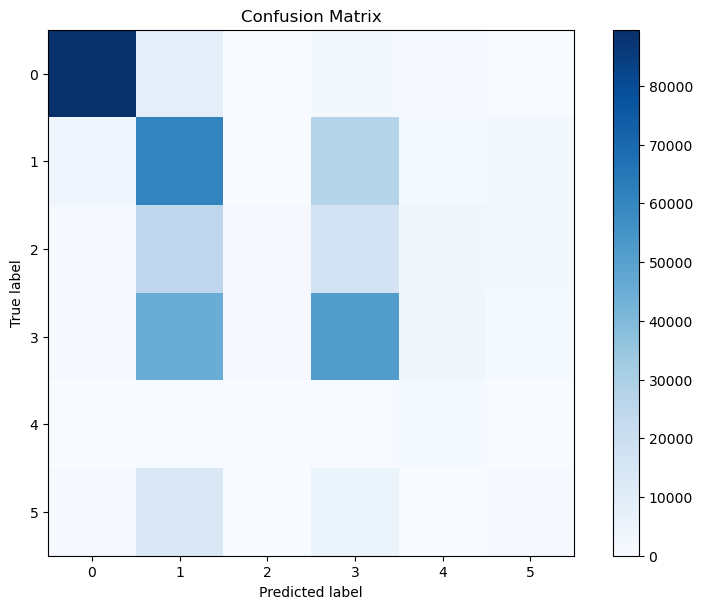

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have already trained your model, evaluate it on your test data
_, acc = model.evaluate([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11], y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

# Get the model predictions
predictions = model.predict([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11])

# Assuming 'y_test_cat' is one-hot encoded, convert it to integer labels
y_test = np.argmax(y_test_cat, axis=3).ravel()

# Flatten the predictions
predicted_labels = np.argmax(predictions, axis=3).ravel()

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title("Confusion Matrix")
plt.colorbar()
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the confusion matrix
plt.show()


3/3 [==============================] - 336s 109s/step - loss: 0.1119 - accuracy: 0.5549
Accuracy is =  55.49288988113403 %
3/3 [==============================] - 339s 109s/step


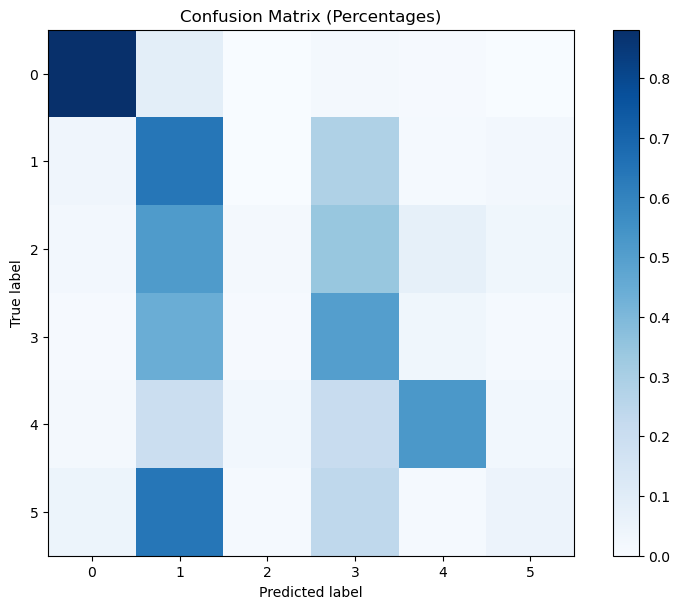

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have already trained your model, evaluate it on your test data
_, acc = model.evaluate([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11], y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

# Get the model predictions
predictions = model.predict([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11])

# Assuming 'y_test_cat' is one-hot encoded, convert it to integer labels
y_test = np.argmax(y_test_cat, axis=3).ravel()

# Flatten the predictions
predicted_labels = np.argmax(predictions, axis=3).ravel()

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, predicted_labels)

# Normalize the confusion matrix to percentages
confusion_matrix_percentages = confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix as a heatmap with percentages
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_percentages, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title("Confusion Matrix (Percentages)")
plt.colorbar()
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the confusion matrix
plt.show()

3/3 [==============================] - 337s 108s/step - loss: 0.1119 - accuracy: 0.5549
Accuracy is =  55.49288988113403 %
3/3 [==============================] - 336s 108s/step


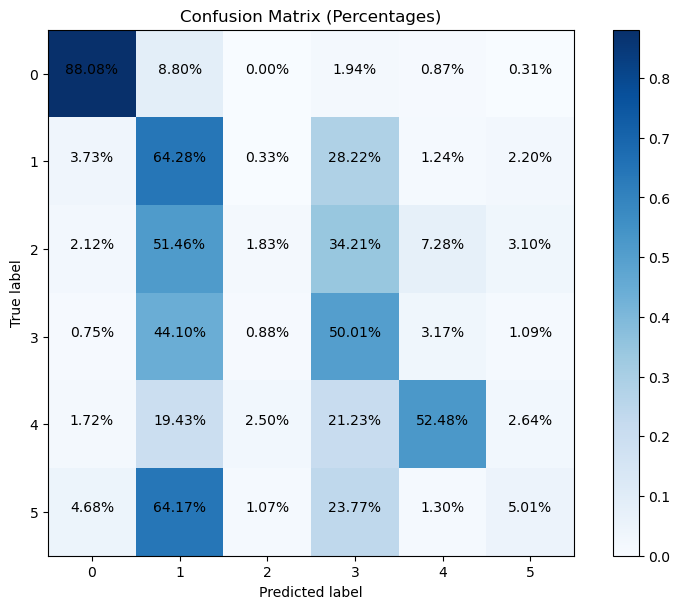

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have already trained your model, evaluate it on your test data
_, acc = model.evaluate([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11], y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

# Get the model predictions
predictions = model.predict([X_test5,X_test7,X_test6,X_test13,X_test1,X_test2,X_test3,X_test4,X_test9,X_test10,X_test8,X_test12,X_test11])

# Assuming 'y_test_cat' is one-hot encoded, convert it to integer labels
y_test = np.argmax(y_test_cat, axis=3).ravel()

# Flatten the predictions
predicted_labels = np.argmax(predictions, axis=3).ravel()

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, predicted_labels)

# Normalize the confusion matrix to percentages
confusion_matrix_percentages = confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix as a heatmap with percentages inside the boxes
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_percentages, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title("Confusion Matrix (Percentages)")
plt.colorbar()
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the boxes with percentage values
for i in range(confusion_matrix_result.shape[0]):
    for j in range(confusion_matrix_result.shape[1]):
        plt.text(j, i, "{:.2f}%".format(confusion_matrix_percentages[i, j] * 100), horizontalalignment="center", color="black")
# Save the confusion matrix as a JPEG image
plt.savefig("confusion_matrix.jpg", format="jpeg")
# Show the confusion matrix
plt.show()


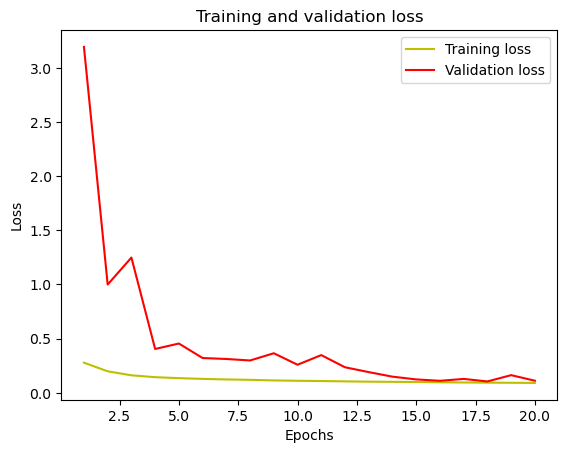

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

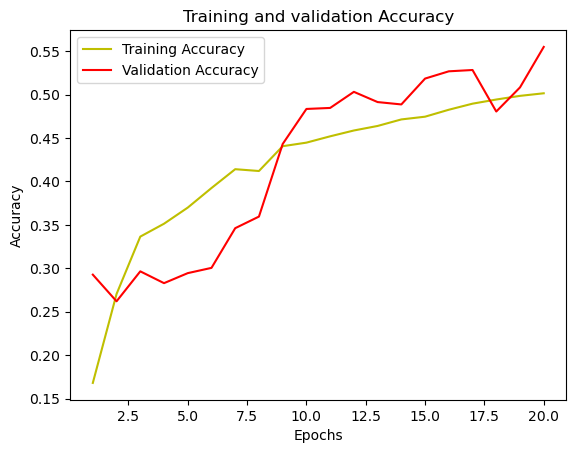

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()